# Multi-modal RAG with LangChain

In [45]:
from dotenv import load_dotenv

load_dotenv()

True

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [59]:
from unstructured.partition.pdf import partition_pdf
import glob

list_of_elements = []

files = glob.glob("../data/*.pdf")

for file_path in files:
    chunks = partition_pdf(
        filename=file_path,
        languages=["ara", "eng"],
        infer_table_structure=True,            # extract tables
        strategy="hi_res",                     # mandatory to infer tables

        extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
        image_output_dir_path='./data/images/',   # if None, images and tables will saved in base64

        extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

        chunking_strategy="basic",          # 'by_title' or 'basic'
        max_characters=10000,                  # defaults to 500
        combine_text_under_n_chars=2000,       # defaults to 0
        new_after_n_chars=6000,
    )
    print(len(chunks))
    list_of_elements.extend(chunks)
print(len(list_of_elements))

1
1
2


In [60]:
list_of_elements[0].metadata.to_dict()

{'filetype': 'application/pdf',
 'languages': ['ara'],
 'last_modified': '2025-02-17T15:18:07',
 'page_number': 1,
 'text_as_html': '<table><thead><tr><th></th><th>التعطيات المسشفى الإقامة و العناية الحثيثة</th></tr></thead><tbody><tr><td></td><td>الفحوصات المخبرية و الأدوية و الإجراءات التشخيصية</td></tr><tr><td></td><td>المرافق للطفل دون (13) سنة</td></tr><tr><td>تغطية كاملة</td><td>سيارة الإسعاف دون تحديد عدد المرات</td></tr><tr><td></td><td>شبكة القلب و الشرايين (STENT)\u200f الحد الأعلى لقيمة الشبكة الواحدة (د.أ)</td></tr></tbody></table> <table><tbody><tr><td>التغطية بنسبة 90100</td><td>السنوي للولادة الطبيعية (د.أ) السقف السنوي للولادة القيصرية (د.أ)</td></tr><tr><td>من ضمان سقف الحالة</td><td></td></tr><tr><td></td><td>السقف السنوي للإجهاض القانوني (د.أ)</td></tr></tbody></table> <table><thead><tr><th>4 زيارة</th><th>غير محددة بسقف سنوي عدد زيارات العلاج خارج المستشفى ( للفرد سنوياً )</th></tr></thead><tbody><tr><td>00 “ya ‘gall 0 49 0 0 و يتحمل المؤمن نسبة 020/ جلسة</td><td>ال

In [61]:
first_doc = list_of_elements[1]
first_doc.text

'666 GULF INSURANCE GROUP\n\nOnline Channels\n\nكباسح ىلا لوخدلا / باسح ءاشنا\n\nGIG Jordan\n\n٠ Mobile App https://apps.apple.com/us/app/gig-jordan/id1287462370\n\nباسحلا حتف وا لوخدلا ليجست ءانثا للخ يا ثودح دنع : كتانايب ثيدحت و يلاتلا طبارلا ىلا لوخدلا ءاجرلا\n\n• https://correctionlink.gig.com.jo/?H7RKFKD0097GFJFJBBOFJF?x6W3S1iO yjcPhPHRDH6YlA==\n\nWebsite :\n\n+ هامضادبةطبية ##برنامهمه ) »شبكتاهطبية | 6الخدماتالإإكترونية | م a + التأمين الطبي (الجماعي /الفردي) [caro]\u200f Travel Insurance a" , 5 rey. 2% Gee 5 3 ١ 0\n\nةيبطلا ةكبشلا\n\nةيبطلا ةكبشلا\n\nMobile app:\n\nMobile app:\n\nanc the cove bag: mar nee dest Online insurance Built around your digital lifeStyle fn) Emergency Home Assistance Policy Avoid bad conditions, hard times and situations by enjoying GIG-Jordan emergency home assistance services, 24/7 emergency technical support through professionals in plumbing, electrical works, and Locksmith also GIG-Jordan extends coverage to include Installation and glass maintenanc

In [62]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in list_of_elements])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [63]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

list_of_elements[0].metadata.orig_elements

In [64]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = list_of_elements[1].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '70fb3be3-0351-4793-85ff-fb6c78786ca0',
 'text': '666 GULF INSURANCE GROUP',
 'metadata': {'coordinates': {'points': ((np.float64(802.9999999999999),
     np.float64(399.66666666666663)),
    (np.float64(802.9999999999999), np.float64(996.3333333333334)),
    (np.float64(1863.6666666666665), np.float64(996.3333333333334)),
    (np.float64(1863.6666666666665), np.float64(399.66666666666663))),
   'system': 'PixelSpace',
   'layout_width': 2667,
   'layout_height': 1500},
  'last_modified': '2025-10-23T12:55:06',
  'filetype': 'PPM',
  'languages': ['ara', 'eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJUBCUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2Jyggk

### Separate extracted elements into tables, text, and images

In [65]:
# separate tables from texts
tables = []
texts = []

for chunk in list_of_elements:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [66]:
print(len(tables))
print(len(texts))

0
2


In [67]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [68]:
print(images)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJUBCUDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

#### Check what the images look like

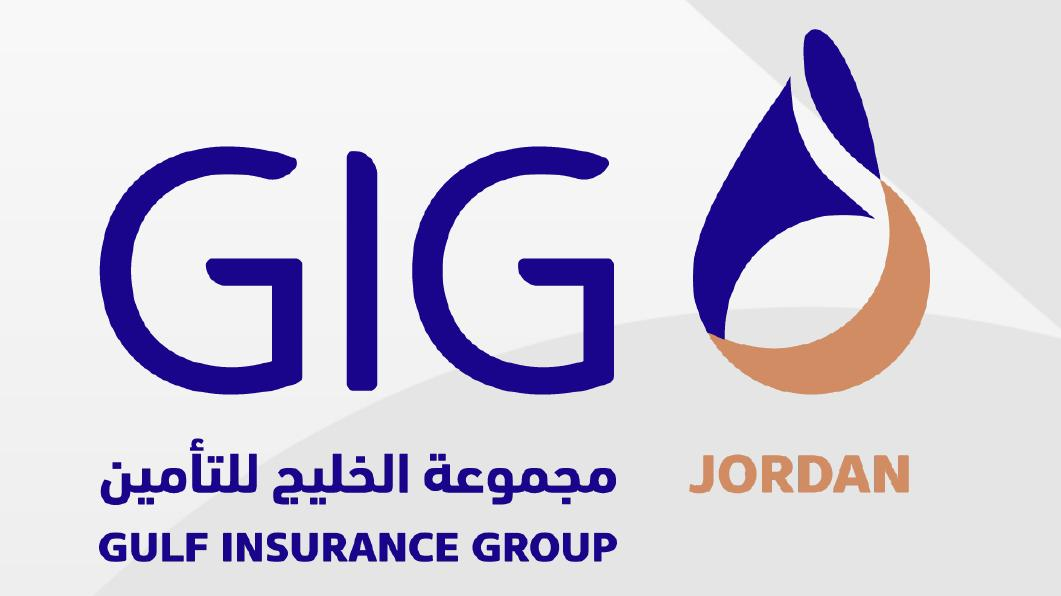

In [69]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [ ]:
%pip install -Uq langchain-groq

In [70]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [71]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [73]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [74]:
text_summaries

['عفانملا لودج يفشتسملا لخاد تايطغتلا، يوجد عدة أنواع من عفانملا لودج مثل STENT و تاصوحفلا، ويتم استخدامها لعلاج حالات مختلفة مثل تارملا ددع و تاصوحفلا.',
 'GIG Jordan is an insurance company offering various services, including medical network, emergency home assistance, travel insurance, and more. They have a mobile app, WhatsApp for Business, and a website for customers to access their services and manage their policies.']

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [ ]:
%pip install -Uq langchain_openai

In [80]:
from langchain_ollama import ChatOllama
import os

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOllama(
    model="llava:latest", 
    base_url=os.getenv("OLLAMA_BASE_URL")
    ) | StrOutputParser()


image_summaries = chain.batch(images)

In [82]:
image_summaries

[' The image features a logo and accompanying text. On the left side, there\'s a logo with a bird-like graphic, resembling an emblem or logo, with some Arabic script underneath it. To the right of this logo, in bold letters against a white background, is the name "جمعية الصحة الاستراتيجية الإبليكة الخليفية أوغندي" (Healthcare Insurance Company - Al-Khalifa Society for Health). Below this text, there is a smaller logo that reads "المؤسسة العامة الإستراتيجية القطرية" (The General Authority for Health Affairs), also in Arabic.\n\nThe logo on the right side of the image includes a stylized graphic resembling a drop or flow, with an arrow pointing downward and a symbol that could be interpreted as a heart or a shield above it. This is followed by the word "جدوي" (Jiddu) in Arabic script, which translates to "Healthcare."\n\nThe logo and accompanying text are set against a background that is not clearly visible but appears to have some blue and white colors. The style of the image suggests i

In [83]:
print(image_summaries[1])

 The image you've provided appears to be a digital graphic with two main elements: a black circle and text. The black circle is positioned in the lower left corner of the image and it is a perfect circle. In the upper right corner, there is text that reads "SUMMERIZER," which could refer to an entity, function, or concept within the context of your research paper on transformers architecture.

Since this is part of a research paper, it's important to note that without additional context from the rest of the paper, it's not possible for me to provide a detailed analysis or interpretation of the image. However, I can infer that the black circle and the text "SUMMERIZER" could be related to some aspect of the transformers architecture, possibly representing an operation or component in the model.

Without additional information from the research paper, I am unable to provide a more detailed description or discuss any potential connections between these elements and the broader field of tr

In [89]:
import pickle

with open('image_summaries.pkl', 'wb') as f:
    pickle.dump(image_summaries, f)

## Load data and summaries to vectorstore

### Create the vectorstore

In [98]:
import langchain; print(langchain.__version__)

1.0.1


In [ ]:
import uuid
from langchain_chroma import Chroma
from langchain_core.stores import InMemoryStore
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_core.retrievers import Pare 

embeddings = OllamaEmbeddings(
    model="embeddinggemma:latest", 
    base_url=os.getenv("OLLAMA_BASE_URL")
    )

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)
                     

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     docstore=store,
#     id_key=id_key,
# )
retriever = vectorstore.as_retriever()

C:\Users\zaid.allawanseh\AppData\Local\Temp\ipykernel_27220\203217479.py:8: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(


### Load the summaries and link the to the original data

In [100]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
# retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
if summary_tables != []:
    retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
# retriever.docstore.mset(list(zip(img_ids, images)))

['49ad4380-66d2-47bf-85f5-c5ff73943618',
 '9d2af0d4-5a73-4082-aa27-b90d457da5e9',
 '6fbab9ff-8259-41d3-91ca-4b3e4c76a559',
 '323c63a1-1b15-4e32-9a88-fa178b9da412',
 'e7601057-3551-403e-80cb-0578aba1f03b',
 '40a590f5-e071-4c24-9724-20d38324f2b4',
 'c51eb727-a2a7-42dd-bba9-053ced681f85',
 '01a95254-1072-4595-af34-fe718ce0db16',
 '1a1632bf-c24d-42b5-aeb1-a947dac54c1d',
 'ee693060-153f-4132-abdd-fb8d0d61c34b',
 'df27e53e-fc39-4301-817b-10e212ac795e',
 '7e1226a5-cfe5-494d-b3b1-ed642ae0b7d4',
 '2b95f818-f76b-4bca-8f91-518427069ea9',
 '103528ac-c98f-4757-93be-44b9df2fcb26',
 'f19e8c4c-06fd-469d-8018-e951a243884c',
 '24ba7ee6-8209-4748-ab5b-1ccf413a80d3',
 'f6ec59f2-c6f4-41fa-a99a-6d30b0eb2291',
 'db52b5bb-d456-41be-afb7-64f1ac796c90',
 '8f548357-4ff2-4ca0-9b64-b52071764cb5',
 '60088586-c05c-4c76-80bf-557c2acd5eb0',
 'f6ec3f10-c283-473c-9da4-d676b8a2fe00']

### Check retrieval

In [101]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [102]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

page_content=' The image you've provided appears to be a product or item with an accompanying logo on a label or sticker at the bottom, but without context, it's challenging to provide a detailed description or explain its relevance to transformers architecture in a research paper. ' metadata={'doc_id': '7ea9412c-0cc2-49f2-9113-31243ca31dbc'}

--------------------------------------------------------------------------------
page_content='GIG Jordan is an insurance company offering various services, including medical network, emergency home assistance, travel insurance, and more. They have a mobile app, WhatsApp for Business, and a website for customers to access their services and manage their policies.' metadata={'doc_id': '3f1cbe3c-0ac6-4534-b579-45e5ea794c6a'}

--------------------------------------------------------------------------------
page_content='GIG Jordan is an insurance company offering various services, including medical network, emergency home assistance, travel insuranc

## RAG pipeline

In [111]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.page_content

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOllama(model="llava:latest", base_url=os.getenv("OLLAMA_BASE_URL"))
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOllama(model="llava:latest", base_url=os.getenv("OLLAMA_BASE_URL"))
        | StrOutputParser()
    )
)

In [112]:
response = chain.invoke("What is the company that provide the insurance?")

print(response)

 GIG Jordan 


In [ ]:
response = chain_with_sources.invoke(
    "How can I access the insurance policy details?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)